In [31]:
import dgl
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import dgllife
from model import MyGAT
from rdkit import Chem
from argparse import Namespace


In [61]:
args = Namespace(
    device = 'cpu',
    model_file   = './models/3/GAT.pt',
    example_file = './dataset/example.csv',
    result_file    = "./dataset/result.csv",
    # -----------------------model hyperparameters------------------------
    in_feats =  74,
    n_classes = 2,
    hidden_feats = [14] * 4, 
    activations  = [F.celu] * 4,
    residuals    = [True] * 4,
    dropouts = [0.2] * 4,
    num_heads = [4] * 4,
    feat_drops = [0.2] * 4,
    attn_drops = [0.2] * 4,
    agg_modes = ['flatten'] * 4,
)


In [19]:
def smile_to_graph(smile, node_featurizer, edge_featurizer):
    graph = smiles_to_bigraph(smile, 
                             node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h'),
                             edge_featurizer = CanonicalBondFeaturizer(bond_data_field='e')
    )
    graph = dgl.remove_self_loop(graph)
    graph = dgl.add_self_loop(graph)
    return graph

In [20]:
def fit(args, model, graphs):
    graphs = graphs.to(args.device)
    node_feats = graphs.ndata.pop('h').to(args.device)
    return model(graphs, node_feats)

## 1. If you just want to predict a few of chemicls.

In [21]:
## step 1. translate smiles to graphs
smiles =  ['CC1CCCCC1OC(C)=O', 'CCC(O)CO', 'CCCCCCCC\C=C/CCCCCCCC(O)=O', 
           'COc1cc(ccc1N)[N+]([O-])=O', 'CCCC[Sn](=O)CCCC','CCCC[Sn](=O)CCCC']

graphs  = [smile_to_graph(smile, None, None) for smile in smiles]
bg = dgl.batch(graphs)  

In [22]:
## step 2: load model
myGAT = MyGAT(args)
myGAT.load_state_dict(torch.load(args.model_file, map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
output, readout, att = fit(args, myGAT, bg)
torch.argmax(output, dim=1)

tensor([0, 0, 0, 1, 1, 1])

## 2. If you want to predict a large number of chemicals, I suggest take those chemicals into a file of csv.

In [24]:
# step 1. read chemicals file
import pandas as pd
data_file = pd.read_csv(args.example_file)
data_file.head()

,smiles
0,CCCCCCCCCCCCCCC
1,NCCCCCCN
2,OCCNCCO
3,CCCCCCCCCCCCCCCCCCOC(=O)CCSCCC(=O)OCCCCCCCCCCC...
4,CCOC(=O)C=C


In [34]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.

    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally a binary
        mask indicating the existence of labels.

    Returns
    -------
    smiles : list
        List of smiles
    bg : DGLGraph
        The batched DGLGraph.
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels.
    """
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if len(data[0]) == 3:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

def get_dataloader(df, batch_size, collate_fn):
    dataset = MoleculeCSVDataset(df = df, 
                                 smiles_to_graph=smile_to_graph,
                                 node_featurizer = None,
                                 edge_featurizer = None,
                                 smiles_column='Smiles', 
                                 cache_file_path="./degradation_example.bin")
    if not get_dataset:
        return DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, collate_fn = collate_fn)
    else:
        return dataset, DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, collate_fn = collate_fn)

In [36]:
## step 2. make datset
batch_size = 10
dataset = MoleculeCSVDataset(df = data_file, 
                                 smiles_to_graph=smile_to_graph,
                                 node_featurizer = None,
                                 edge_featurizer = None,
                                 smiles_column='smiles', 
                                 cache_file_path="./degradation_dataset.bin")
data_loader = DataLoader(dataset = dataset, batch_size = batch_size, collate_fn = collate_molgraphs)

Processing dgl graphs from scratch...


In [44]:
## setp 3. load model
myGAT = MyGAT(args)
myGAT.load_state_dict(torch.load(args.model_file, map_location=torch.device('cpu')))

<All keys matched successfully>

In [66]:
## step 4. fit
myGAT.eval()
result = []
for idx, data in enumerate(data_loader):
    smiles, graphs, _,_ = data
    logits, readout, att = fit(args, myGAT, graphs)
    result.extend(torch.argmax(logits.detach(), dim=1).tolist())
#result

In [68]:
## step 5. save result
result =  pd.DataFrame(result)
result.to_csv(args.result_file, index=None, header=None)

## 3. If you want to observe attention score on chemicals structure

In [81]:
from functools import partial
from IPython.display import SVG, display
import matplotlib
import matplotlib.cm as cm
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [110]:
def svg_draw(mol, g, node_attention, bond_attention):
    """
        mol_to_svg:
        args:
            mol: mol object of rdkit
            grapg: 
            node_attention: 节点attention
            bond_attention: 节点attention
        return: svg
    """
    # 绘制edge_attention
    min_value = torch.min(bond_attention)
    max_value = torch.max(bond_attention)
    bond_attention = (bond_attention - min_value) // (max_value - min_value) # normalization
    # Conver the weights to atom colors
    #norm = matplotlib.colors.Normalize(vmin=0, vmax=1.0)
    norm = matplotlib.colors.Normalize(vmin=min_value, vmax=max_value)
    cmap = cm.get_cmap('Accent')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    bond_colors = {i: plt_colors.to_rgba(bond_attention[i*2].data.item()) for i in range((g.number_of_edges()-g.number_of_nodes())//2)}

    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(500,250)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    #print(len(bond_colors), len(list(range(g.number_of_edges() // 2))))
    drawer.DrawMolecule(mol,highlightAtoms=None,highlightBonds=list(range(len(bond_colors))), highlightBondColors=bond_colors)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    return svg

In [111]:
def draw(mol_idxs,  dataset, model, col=None):
    """Visualize the learned atom weights in readout && bond attention.
    
    Parameters
    ----------
    mol_id : int
        Index for the molecule to visualize in the dataset.
    dataset
        As the model has multiple rounds of readout, an additional
        index is used to specify the round for the weights.
    """
    # Get the weights from the model.

    smiles = []
    graphs = []
    for idx in mol_idxs:
        smile, g, _, _ = dataset[idx]
        smiles.append(smile)
        graphs.append(g)
    
    bg = dgl.batch(graphs)  

    logit, readout, bond_attentions = fit(args, model, bg)
    bond_attention_split = []
    if col is not None: 
        bond_attentions = torch.squeeze(bond_attentions)[:, col]
        for i in range(len(bg.batch_num_edges())):
            if i == 0:
                bond_attention = bond_attentions[0:bg.batch_num_edges()[0].item()]
            else:
                bond_attention = bond_attentions[
                    torch.sum(bg.batch_num_edges()[:i]).item():
                    torch.sum(bg.batch_num_edges()[:i+1]).item()]
            bond_attention_split.append(bond_attention)
    else:
        for i in range(len(bg.batch_num_edges())):
            if i == 0:
                bond_attention, _= torch.max(bond_attentions[0:bg.batch_num_edges()[0].item()], dim=1)
            else:
                bond_attention, _= torch.max(bond_attentions[
                    torch.sum(bg.batch_num_edges()[:i]).item() :
                    torch.sum(bg.batch_num_edges()[:i+1]).item()
                    ], dim=1)
                bond_attention = torch.tensor([1 if i > 0.5 else  0 for i in bond_attention.detach().cpu()])
            bond_attention_split.append(bond_attention)
    mols = [Chem.MolFromSmiles(s) for s in smiles]

    svgs = [svg_draw(mols[i], graphs[i], None, bond_attention_split[i].squeeze()) for i in range(len(graphs))]
    for i in range(len(graphs)):
        display(SVG(svgs[i]))

Processing dgl graphs from scratch...


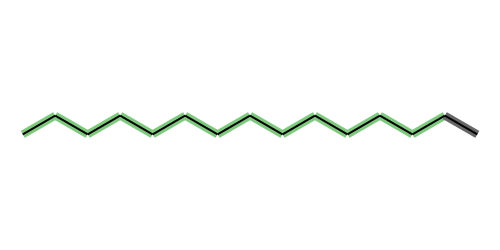

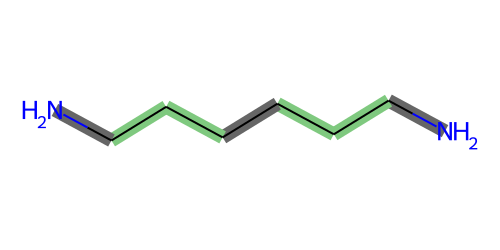

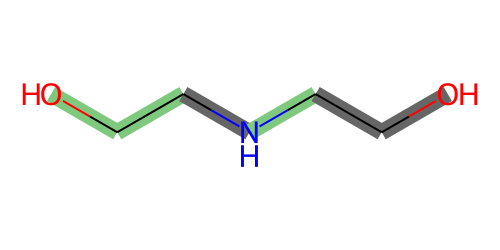

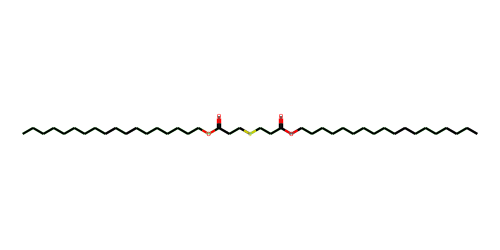

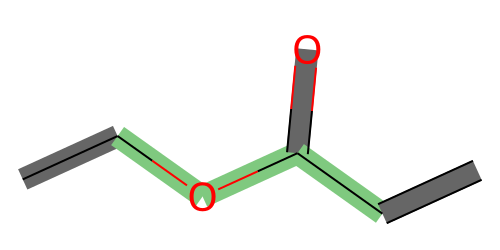

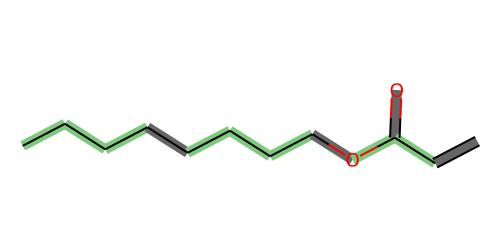

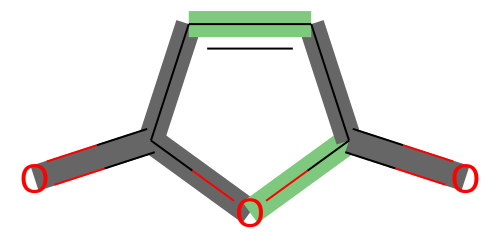

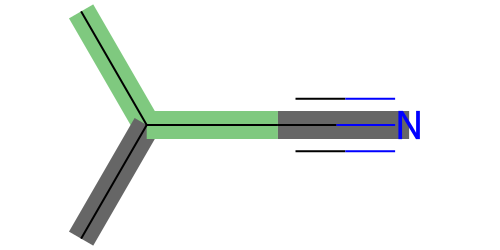

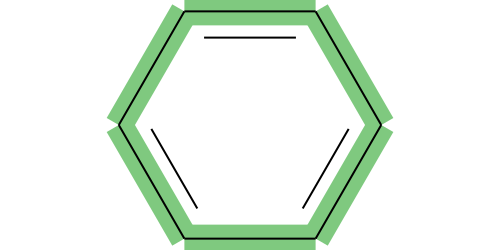

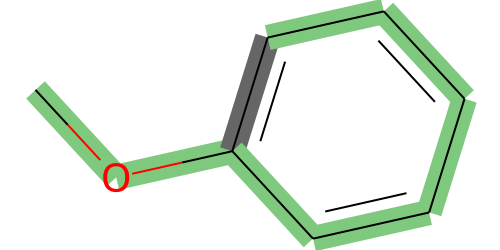

In [112]:
dataset = MoleculeCSVDataset(df = data_file, 
                                 smiles_to_graph=smile_to_graph,
                                 node_featurizer = None,
                                 edge_featurizer = None,
                                 smiles_column='smiles', 
                                 cache_file_path="./degradation_dataset.bin")
# step 1. you should specify index on dataste that you want to draw.                 
draw_list =  list(range(0,10))
# step 2. load model
myGAT = MyGAT(args)
myGAT.load_state_dict(torch.load(args.model_file, map_location=torch.device('cpu')))
# step 3. draw
draw(draw_list,  dataset, myGAT, col=None)